# 一、比賽簡介

這是2912年，在宇宙中有約13000位乘客在Spaceship Titanic上，但是航行出了意外，需要預測乘客是否被運送到別的維度，以利搜查工作。   
我會選擇這個比賽是因為這和課堂中的例子很相似，可以自己重複練習課堂中所使用的工具和方法，加深印象，也驗證自己是否真的會使用那些方法，能夠套用在相似的資料集上，用以檢視學習成效。

### 資料集敘述

總共有8693筆資料，以下是各個欄位的敘述。   
PassengerId - 乘客獨特的編號，形式是 gggg_pp，gggg是團隊名稱，pp是乘客在團隊中的編號。   
HomePlanet - 乘客原居住地。   
CryoSleep - 乘客在飛行過程中是否使用「暫停生命」服務。   
Cabin - 乘客座艙編號。形式是 甲板/編號/船側, 船側P表示右舷，S表示左舷。   
Destination - 目的地。   
Age - 年齡。   
VIP - 乘客是否為VIP。   
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - 數值資料，乘客在各項所花費的錢。  
Name - 乘客名字。   
Transported - 乘客是否被運送到別的維度。這是預測目標。

# 二、如何實作

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## (一) 資料觀察

In [2]:
df = pd.read_csv('./train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


#### 觀察以目標欄位群組後數值欄位的平均
發現RoomService、Spa、VRDeck數值有明顯差異

In [4]:
df.groupby('Transported').mean()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Transported,,,,,,
False,29.922858,389.266066,382.615930,167.566217,564.382666,543.629822
True,27.748834,63.098021,532.691984,179.829972,61.675531,69.148131


#### 圖像化觀察其他欄位和Transported的關聯
因為資料型態不符，所以將此步驟移至後面展示

In [5]:
# sns.pairplot(df[['Transported', 'CryoSleep']], dropna=True)
# # dropna: Drop missing values from the data before plotting.

In [6]:
# sns.pairplot(df[['Transported', 'Age']], dropna=True)

#### 將覺得無關的欄位刪除

In [7]:
df.drop(['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Name'], axis=1, inplace=True)
df.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,False,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,False,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,False,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,False,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,False,16.0,False,303.0,70.0,151.0,565.0,2.0,True


## (二) 資料前處理

### 1. 空值處理

In [8]:
df.isnull().sum()

CryoSleep       217
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

### 以最多的類別填補

CryoSleep、VIP

In [9]:
df['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [10]:
df['CryoSleep'].fillna(df['CryoSleep'].value_counts().idxmax(), inplace=True)

In [11]:
df['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [12]:
df['VIP'].fillna(df['VIP'].value_counts().idxmax(), inplace=True)

### 以中位數填補

Age、RoomService、FoodCourt、ShoppingMall、Spa、VRDeck

In [13]:
column = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for col in column:
    df[col].fillna(df[col].median(), inplace=True)

In [14]:
#所有缺失值搞定!
df.isnull().sum()

CryoSleep       0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

### 2. 資料型態轉換

#### 參考資料
資料型態轉換 https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CryoSleep     8693 non-null   bool   
 1   Age           8693 non-null   float64
 2   VIP           8693 non-null   bool   
 3   RoomService   8693 non-null   float64
 4   FoodCourt     8693 non-null   float64
 5   ShoppingMall  8693 non-null   float64
 6   Spa           8693 non-null   float64
 7   VRDeck        8693 non-null   float64
 8   Transported   8693 non-null   bool   
dtypes: bool(3), float64(6)
memory usage: 433.1 KB


把bool都換成數值型態   
CryoSleep、VIP、Transported

In [16]:
bool_column = ['CryoSleep', 'VIP', 'Transported']
for col in bool_column:
    df[col] = df[col].astype('uint8')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CryoSleep     8693 non-null   uint8  
 1   Age           8693 non-null   float64
 2   VIP           8693 non-null   uint8  
 3   RoomService   8693 non-null   float64
 4   FoodCourt     8693 non-null   float64
 5   ShoppingMall  8693 non-null   float64
 6   Spa           8693 non-null   float64
 7   VRDeck        8693 non-null   float64
 8   Transported   8693 non-null   uint8  
dtypes: float64(6), uint8(3)
memory usage: 433.1 KB


#### 圖像化觀察其他欄位和Transported的關聯
因為資料型態不符，所以將此步驟移至後面展示

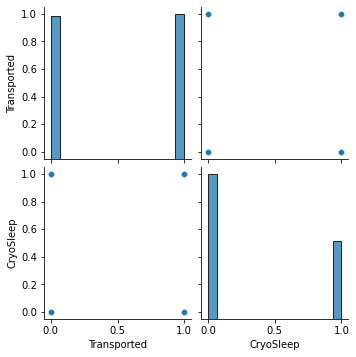

In [18]:
sns.pairplot(df[['Transported', 'CryoSleep']], dropna=True)
# dropna: Drop missing values from the data before plotting.

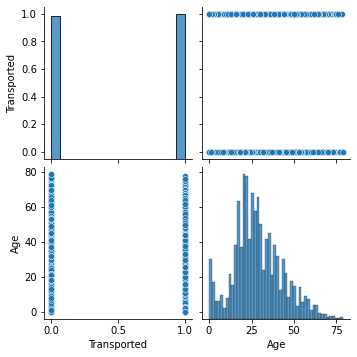

In [19]:
sns.pairplot(df[['Transported', 'Age']], dropna=True)

## (三) 資料切割
將剛剛處理好的資料把目標欄位分開，並分成訓練和測試資料。

In [20]:
df.corr()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
CryoSleep,1.000000,-0.071323,-0.078281,-0.244089,-0.205928,-0.207798,-0.198307,-0.192721,0.460132
Age,-0.071323,1.000000,0.091863,0.068629,0.127390,0.033148,0.120946,0.099590,-0.074233
VIP,-0.078281,0.091863,1.000000,0.056566,0.125499,0.018412,0.060991,0.123061,-0.037261
RoomService,-0.244089,0.068629,0.056566,1.000000,-0.015126,0.052337,0.009244,-0.018624,-0.241124
FoodCourt,-0.205928,0.127390,0.125499,-0.015126,1.000000,-0.013717,0.221468,0.224572,0.045583
ShoppingMall,-0.207798,0.033148,0.018412,0.052337,-0.013717,1.000000,0.014542,-0.007849,0.009391
Spa,-0.198307,0.120946,0.060991,0.009244,0.221468,0.014542,1.000000,0.147658,-0.218545
VRDeck,-0.192721,0.099590,0.123061,-0.018624,0.224572,-0.007849,0.147658,1.000000,-0.204874
Transported,0.460132,-0.074233,-0.037261,-0.241124,0.045583,0.009391,-0.218545,-0.204874,1.000000


各欄位間無明顯相關性，所以全部都取作用為訓練欄位。

#### 準備訓練資料集

In [21]:
#把Transported丟掉
X=df.drop(['Transported'],axis=1)
y=df['Transported']

#split to training data & testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=67)

## (四) Model
將切割好的資料餵進模型內，並生成預測結果。

In [22]:
# using Logistic refression model
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

## (五) 評估
上一個步驟我們訓練好Logistic Regression 模型，觀察幾個指標數據來看模型成效。

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

In [24]:
accuracy_score(y_test, predictions)

0.781058282208589

In [25]:
recall_score(y_test, predictions)

0.7964939024390244

In [26]:
precision_score(y_test, predictions)

0.7746478873239436

In [27]:
pd.DataFrame(confusion_matrix(y_test, predictions),columns=['Predict not Survived', 'Predict Survived'],index=['True not Survived','True Survived'])

,Predict not Survived,Predict Survived
True not Survived,992,304
True Survived,267,1045


## (六) 調整測試資料集以符合模型 
運用訓練好的模型，將它套用在測試資料集上，並把結果做成符合比賽規範的格式。

In [28]:
df_test = pd.read_csv('./test.csv')

In [29]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [30]:
PassenferId = df_test['PassengerId'] # 把ID存起來，做提交資料用

# 資料前處理
df_test.drop(['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Name'], axis=1, inplace=True)
df_test['CryoSleep'].fillna(df_test['CryoSleep'].value_counts().idxmax(), inplace=True)
df_test['VIP'].fillna(df['VIP'].value_counts().idxmax(), inplace=True)
for col in column:
    df_test[col].fillna(df_test[col].median(), inplace=True)
test_bool_column = ['CryoSleep', 'VIP']
for col in test_bool_column:
    df_test[col] = df_test[col].astype('uint8')

In [31]:
df_test.isnull().sum()

CryoSleep       0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

In [32]:
# 執行
predictions2 = lr.predict(df_test)

In [33]:
#prepare submit file
forSubmissionDF = pd.DataFrame(columns=['PassengerId', 'Transported'])
forSubmissionDF['PassengerId'] = PassenferId
forSubmissionDF['Transported'] = predictions2
forSubmissionDF['Transported'] = forSubmissionDF['Transported'].astype(bool)
forSubmissionDF

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [34]:
forSubmissionDF.to_csv('SpaceshipTitanic_lr.csv', index=False)

此資料集與課堂中的Titanic練習都是類別預測，欄位處理也都是和課堂中的方式相似，並增加一些其他的處理流程。   
在找資料的過程中，發現除了原本的Logistic Regression模型，也有其他種類的模型：Decision Tree、Random Forest、Support Vector Machine (SVM)、 K-Nearest Neighbour (KNN)、Naive Bayes。   
在處理數值資料時，也建議先將各欄位標準化，以利比較與模型訓練，而標準化也有很多種方法，其中常見的有：Max-Min、Z-Score、MaxAbs、RobustScaler。

# 三、 比賽結果

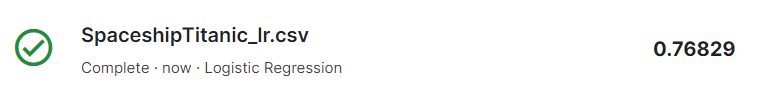

以Logistic Regression模型提交的結果拿到0.76的分數。

## 推測改善方式與嘗試結果

### 1. 改變模型max_iter
模型可能會欠擬合或是過度擬合，所以試著改變max_iter。   
參考資料： https://ithelp.ithome.com.tw/articles/10221245

In [35]:
lr = LogisticRegression(max_iter=100) #降低 max_iter
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [36]:
accuracy_score(y_test, predictions)

0.781058282208589

In [37]:
pd.DataFrame(confusion_matrix(y_test, predictions),columns=['Predict not Survived', 'Predict Survived'],index=['True not Survived','True Survived'])

,Predict not Survived,Predict Survived
True not Survived,992,304
True Survived,267,1045


In [38]:
lr = LogisticRegression(max_iter=1000) #提升 max_iter
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [39]:
accuracy_score(y_test, predictions)

0.781058282208589

In [40]:
pd.DataFrame(confusion_matrix(y_test, predictions),columns=['Predict not Survived', 'Predict Survived'],index=['True not Survived','True Survived'])

,Predict not Survived,Predict Survived
True not Survived,992,304
True Survived,267,1045


發現結果和原本一模一樣。

### 2. 資料標準化
因為其中有一些欄位為數值資料，所以可能在前處理時可以先將該欄位標準化。   
不同資料欄位與資料值所組成，分佈狀況可能都不盡相同，因此，就必須將特徵資料按比例縮放，讓資料落在某一特定的區間。

參考資料: https://ithelp.ithome.com.tw/articles/10216967

#### Z-Score標準化法

In [41]:
from sklearn import preprocessing
#建立StandardScaler物件
zscore = preprocessing.StandardScaler()
# 資料標準化
data_zs = pd.DataFrame(zscore.fit_transform(df),
                                columns=df.keys())

#將bool值欄位填回原本的資料
bool_column = ['CryoSleep', 'VIP', 'Transported']
for col in bool_column:
    data_zs[col] = df[col]

In [42]:
data_zs

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0,0.711945,0,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,0
1,0,-0.334037,0,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,1
2,0,2.036857,1,-0.268001,1.959998,-0.283579,5.695623,-0.219796,0
3,0,0.293552,0,-0.333105,0.523010,0.336851,2.687176,-0.092818,0
4,0,-0.891895,0,0.125652,-0.237159,-0.031059,0.231374,-0.261240,1
...,...,...,...,...,...,...,...,...,...
8688,0,0.851410,1,-0.333105,3.992336,-0.283579,1.189173,-0.197751,0
8689,1,-0.752431,0,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,0
8690,0,-0.194573,0,-0.333105,-0.281027,2.846999,-0.269737,-0.263003,1
8691,0,0.223820,0,-0.333105,0.376365,-0.283579,0.043013,2.589576,0


In [43]:
#把Transported丟掉
X=data_zs.drop(['Transported'],axis=1)
y=data_zs['Transported']

#split to training data & testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=67)

In [44]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [45]:
accuracy_score(y_test, predictions)

0.781441717791411

In [46]:
pd.DataFrame(confusion_matrix(y_test, predictions),columns=['Predict not Survived', 'Predict Survived'],index=['True not Survived','True Survived'])

,Predict not Survived,Predict Survived
True not Survived,993,303
True Survived,267,1045


發現結果和原本一模一樣。

#### 再使用Max-Min標準化方法試試看

In [47]:
from sklearn import preprocessing
#建立MinMaxScaler物件
minmax = preprocessing.MinMaxScaler()
# 資料標準化
data_minmax = pd.DataFrame(minmax.fit_transform(df),
                                columns=df.keys())

#將bool值欄位填回原本的資料
# 因為minmax會將資料映射到[0,1]所以bool值不用另外處理

In [48]:
data_minmax

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0.0,0.493671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.303797,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,1.0
2,0.0,0.734177,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.0
3,0.0,0.417722,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.0
4,0.0,0.202532,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,1.0
...,...,...,...,...,...,...,...,...,...
8688,0.0,0.518987,1.0,0.000000,0.228726,0.000000,0.073322,0.003066,0.0
8689,1.0,0.227848,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
8690,0.0,0.329114,0.0,0.000000,0.000000,0.079687,0.000045,0.000000,1.0
8691,0.0,0.405063,0.0,0.000000,0.035186,0.000000,0.015753,0.134049,0.0


In [49]:
#把Transported丟掉
X=data_minmax.drop(['Transported'],axis=1)
y=data_minmax['Transported']

#split to training data & testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=67)

In [50]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [51]:
accuracy_score(y_test, predictions)

0.7599693251533742

In [52]:
pd.DataFrame(confusion_matrix(y_test, predictions),columns=['Predict not Survived', 'Predict Survived'],index=['True not Survived','True Survived'])

,Predict not Survived,Predict Survived
True not Survived,1129,167
True Survived,459,853


In [53]:
recall_score(y_test, predictions)

0.6501524390243902

In [54]:
precision_score(y_test, predictions)

0.8362745098039216

發現預測結果的分布和原本不相同，多觀察了召回率和準確率，並重新再提交一次結果。

In [55]:
maxmin_predictions2 = lr.predict(df_test)

In [56]:
maxmin_forSubmissionDF = pd.DataFrame(columns=['PassengerId', 'Transported'])
maxmin_forSubmissionDF['PassengerId'] = PassenferId
maxmin_forSubmissionDF['Transported'] = predictions2
maxmin_forSubmissionDF['Transported'] = forSubmissionDF['Transported'].astype(bool)
maxmin_forSubmissionDF

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [57]:
maxmin_forSubmissionDF.to_csv('SpaceshipTitanic_maxmin.csv', index=False)

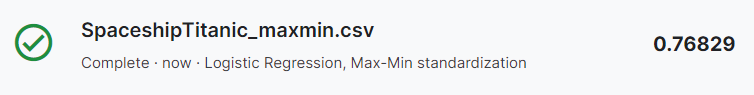

比賽分數結果還是一樣。

### 3. 使用不同模型

In [58]:
# 建立模型
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

In [59]:
accuracy_score(y_test, rf_predictions)

0.7921779141104295

In [60]:
pd.DataFrame(confusion_matrix(y_test, rf_predictions),columns=['Predict not Survived', 'Predict Survived'],index=['True not Survived','True Survived'])

,Predict not Survived,Predict Survived
True not Survived,981,315
True Survived,227,1085


發現精準率有些許提升，所以重新再提交一次結果。

In [61]:
rf_predictions2 = lr.predict(df_test)

In [62]:
rf_forSubmissionDF = pd.DataFrame(columns=['PassengerId', 'Transported'])
rf_forSubmissionDF['PassengerId'] = PassenferId
rf_forSubmissionDF['Transported'] = predictions2
rf_forSubmissionDF['Transported'] = forSubmissionDF['Transported'].astype(bool)
rf_forSubmissionDF

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [63]:
rf_forSubmissionDF.to_csv('SpaceshipTitanic_rf.csv', index=False)

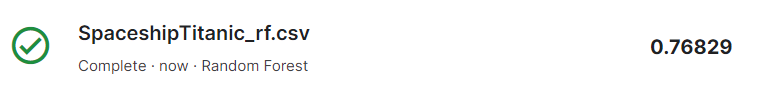

比賽分數結果還是一樣。

### 4. 採用不同欄位

根據前面的觀察，以目標欄位群組後求數值欄位的平均，發現RoomService、Spa、VRDeck數值有明顯差異。只取這三個欄位來預測結果。

In [64]:
df2 = df[['RoomService', 'Spa', 'VRDeck', 'Transported']]
df2

,RoomService,Spa,VRDeck,Transported
0,0.0,0.0,0.0,0
1,109.0,549.0,44.0,1
2,43.0,6715.0,49.0,0
3,0.0,3329.0,193.0,0
4,303.0,565.0,2.0,1
...,...,...,...,...
8688,0.0,1643.0,74.0,0
8689,0.0,0.0,0.0,0
8690,0.0,1.0,0.0,1
8691,0.0,353.0,3235.0,0


In [65]:
#把Transported丟掉
X=df2.drop(['Transported'],axis=1)
y=df2['Transported']

#split to training data & testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=67)

In [66]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
df2_predictions = lr.predict(X_test)

In [67]:
accuracy_score(y_test, df2_predictions)

0.7664877300613497

In [68]:
pd.DataFrame(confusion_matrix(y_test, df2_predictions),columns=['Predict not Survived', 'Predict Survived'],index=['True not Survived','True Survived'])

,Predict not Survived,Predict Survived
True not Survived,847,449
True Survived,160,1152


In [69]:
recall_score(y_test, predictions)

0.6501524390243902

In [70]:
precision_score(y_test, predictions)

0.8362745098039216

發現預測結果的分布和原本不相同，多觀察了召回率和準確率，並重新再提交一次結果。

In [71]:
df2_predictions2 = lr.predict(df_test[['RoomService', 'Spa', 'VRDeck']])

In [72]:
df2_forSubmissionDF = pd.DataFrame(columns=['PassengerId', 'Transported'])
df2_forSubmissionDF['PassengerId'] = PassenferId
df2_forSubmissionDF['Transported'] = predictions2
df2_forSubmissionDF['Transported'] = forSubmissionDF['Transported'].astype(bool)
df2_forSubmissionDF

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [73]:
maxmin_forSubmissionDF.to_csv('SpaceshipTitanic_df2.csv', index=False)

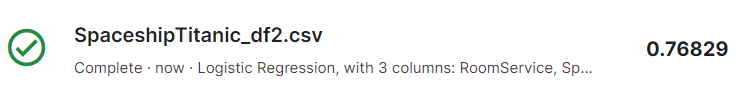

比賽分數結果還是一樣。